# To-Do
- Join data tables 
 - Set time intervals to 5 minutes
- Feature engineering
 - Weekday from date **(DONE)**
 - day time 00:00 - 23:00 **(DONE)**
 - month 1-12 **(DONE)**
 - rush hour
- Data Augmentation
 - Enhance weather data by looking up the dates on the web in the city


**Model Building**
- Cluster common routes
- Build a model to predict traffic rating 
 - Build base line logistic regression model **(DONE)**
 - Build random forest classifier
 - Include Cross Validation
- Include ROC, AUC plots

## Data Set Description
The dataset is composed by two tables. The first table **tracks** presents general 
attributes and each instance has one trajectory that is represented by the table  
**trackspoints**. 

### Tracks Data Table - a list of trajectories  
- id_android - it represents the device used to capture the instance;  
- speed - it represents the average speed (Km/H)  
- time - it represents the time in hours
- distance - it represent the total distance (Km)  
- rating - it is an evaluation parameter. Evaluation the traffic is a way to verify the volunteers 
  perception about the traffic during the travel, in other words,  
  if volunteers move to some place and face traffic jam, maybe they will    evaluate 'bad'. (3-good, 2-normal, 1-bad).  
- rating_bus - it is other evaluation parameter. (1 - The amount of people inside the bus is little, 2 - The bus is not crowded, 3- The bus is crowded.  
- rating_weather - it is another evaluation parameter. ( 2- sunny, 1- raining).  
- car_or_bus - (1 - car, 2-bus)  
- linha - information about the bus that does the pathway  

### Trackspoints Data Table -  localization points of each trajectory  
- id: unique key to identify each point  
- latitude: latitude from where the point is  
- longitude: longitude from where the point is  
- track_id: identify the trajectory which the point belong  
- time: datetime when the point was collected (GMT-3) 

In [158]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
#Visualisation Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import seaborn as sns


# Self written packages
from data.make_data import DataSet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("Start reading data:")
parentdir = os.path.dirname(os.getcwd())
datadir = os.path.join(parentdir, "data", "preprocessed")
dataset = DataSet(datadir,file_ending=".csv")
tracks, trackspoints = dataset.get_data()
trackspoints = dataset._preprocess_trackspoint_data(trackspoints)

Start reading data:


Tracks data set

In [3]:
print("Number of data records: ", len(tracks))

tracks.iloc[0:10]

Number of data records:  129


,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
0,1,0,19.210586,8.27,2.652,3,0,0,no_answer,1
1,2,0,30.848229,10.22,5.290,3,0,0,no_answer,1
2,3,1,13.560101,3.90,0.918,3,0,0,no_answer,0
3,4,1,19.766679,27.18,7.700,3,0,0,no_answer,0
4,8,0,25.807401,1.73,3.995,2,0,0,no_answer,1
5,10,2,1.346913,0.17,0.009,2,0,0,no_answer,1
6,11,3,36.850787,13.47,8.402,3,0,0,no_answer,1
7,12,1,17.405131,2.30,0.675,3,0,0,no_answer,0
8,13,1,15.395436,31.52,8.111,3,0,0,no_answer,0
9,16,3,15.041348,13.05,3.277,3,0,0,no_answer,1


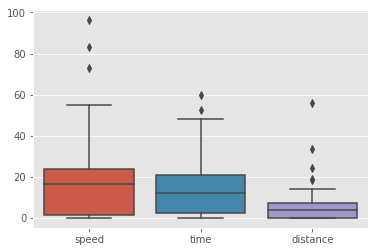

In [4]:
sns.boxplot(data=tracks[['speed','time','distance']]);

Trackspoints data set

In [5]:
print("Number of data records: ", len(trackspoints))
trackspoints.iloc[0:10]

Number of data records:  14206


,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53
5,6,-10.938544,-37.062839,1,2014-09-13 07:24:59
6,7,-10.938346,-37.062588,1,2014-09-13 07:25:04
7,8,-10.938448,-37.062000,1,2014-09-13 07:25:10
8,9,-10.938666,-37.061499,1,2014-09-13 07:25:15
9,10,-10.938986,-37.060819,1,2014-09-13 07:25:21


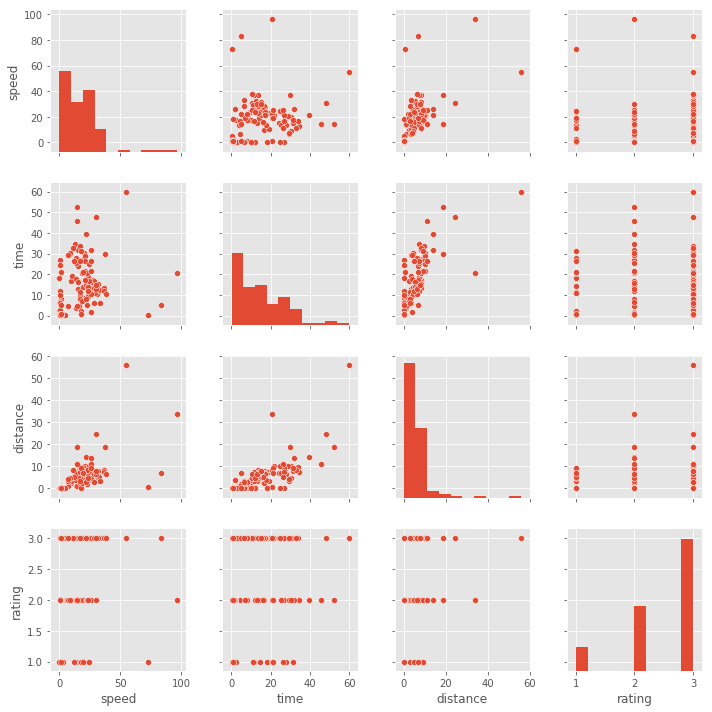

In [6]:
tracks_cor = tracks[['speed','time','distance','rating']]

sns.pairplot(tracks_cor)
plt.tight_layout()
plt.show();

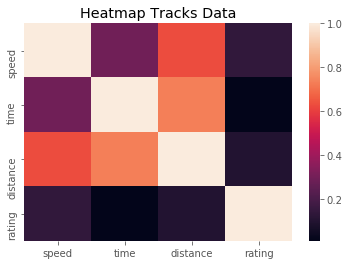

In [7]:
# Calculate correlations
corr = tracks[['speed','time','distance','rating']].corr()
# Heatmap
heatmap = sns.heatmap(corr);
heatmap.set_title("Heatmap Tracks Data");

**Observe the outliers:**

Outliers for speed > 50 $\frac{km}{h}$

In [8]:
tracks[tracks["speed"]>50]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
31,51,2,72.926755,0.37,0.661,1,0,0,no_answer,0
33,55,1,83.328135,4.98,6.976,3,0,0,no_answer,1
34,58,6,96.206029,20.68,33.739,2,0,0,no_answer,0


Outliers for time > 40 minutes

In [9]:
tracks[tracks["time"]>40]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
83,37962,12,14.712053,52.42,18.819,2,0,0,carro,1
98,38002,12,30.397045,47.93,24.461,3,0,0,carro,1
104,38017,16,14.630896,45.80,11.218,2,0,0,carro,1


Outliers for distance > 20 km

In [10]:
tracks[tracks["distance"]>20]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
34,58,6,96.206029,20.68,33.739,2,0,0,no_answer,0
98,38002,12,30.397045,47.93,24.461,3,0,0,carro,1


**We have an unbalanced data set**

In [11]:
for rating in range(1,4):
    nr_of_rated_tracks = len(tracks[tracks["rating"]==rating])
    percentage = round(nr_of_rated_tracks/len(tracks) * 100)
    print("Number tracks with rating {}: {} thats {}% of observations".format(rating, nr_of_rated_tracks,
                                                                              percentage))

Number tracks with rating 1: 14 thats 11% of observations
Number tracks with rating 2: 38 thats 29% of observations
Number tracks with rating 3: 77 thats 60% of observations


There are much more observations with rating 3, than of the others, where rating is the subjective user rating of the traffic and 3=good, 2=normal, 1=bad.

----
## Feature Engineering

Construct weekday and daytime features by mapping the features to the unit circle. This captures the cyclicle nature of the weekday, hours and months variable. The idea is from a blog post on [kdnuggets](https://www.kdnuggets.com/2017/10/top-errors-novice-machine-learning-engineers.html?utm_content=buffer4acd4&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer)


In [12]:
from features.make_features import apply_feature_engineering

feature_engineered_tracks = apply_feature_engineering(tracks, trackspoints)

In [13]:
feature_engineered_tracks.head()

,speed,time,distance,rating,car_or_bus,month_sinus,month_cosinus,weekday_sinus,weekday_cosinus,daytime_start_sinus,daytime_start_cosinus,daytime_end_sinus,daytime_end_cosinus
0,0.178463,-0.466230,-0.347570,3,1,-0.866025,-0.5,-0.974928,-0.222521,0.933580,-0.358368,0.920508,-0.390723
1,0.921676,-0.309100,0.040259,3,1,-0.866025,-0.5,-0.974928,-0.222521,-0.410727,-0.911758,-0.453990,-0.891007
2,-0.182393,-0.818363,-0.602497,3,0,-0.866025,-0.5,0.974928,-0.222521,0.975342,0.220697,0.979047,0.203633
3,0.213977,1.057528,0.394568,3,0,-0.866025,-0.5,0.974928,-0.222521,0.975342,0.220697,0.994522,0.104528
4,0.599754,-0.993220,-0.150128,2,1,-0.866025,-0.5,-0.433884,-0.900969,-0.782603,-0.622521,-0.788016,-0.615655


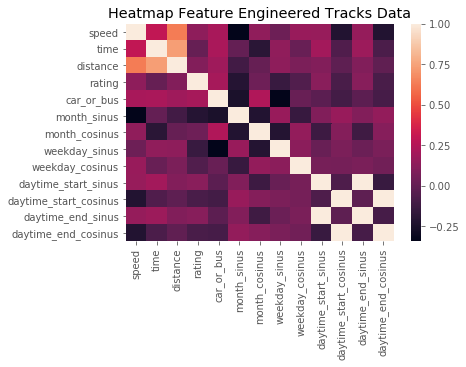

In [14]:
# Calculate correlations
corr = feature_engineered_tracks.corr()
# Heatmap
heatmap = sns.heatmap(corr);
heatmap.set_title("Heatmap Feature Engineered Tracks Data");

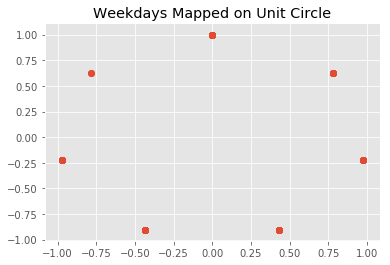

In [15]:
plt.title("Weekdays Mapped on Unit Circle")
plt.scatter(feature_engineered_tracks["weekday_sinus"],
            feature_engineered_tracks["weekday_cosinus"]);


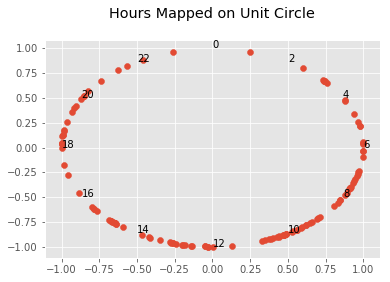

In [16]:
from features.make_features import map_to_sinus
from features.make_features import map_to_cosinus

fig, ax = plt.subplots()
ax.set_title("Hours Mapped on Unit Circle\n")

sinus_mapping = map_to_sinus(pd.DataFrame(np.arange(0,24),columns=["hours"]),"hours")
cosinus_mapping = map_to_cosinus(pd.DataFrame(np.arange(0,24),columns=["hours"]),"hours")

for i in range(0,24,2):
    ax.annotate(str(i),(sinus_mapping[i], cosinus_mapping[i]),
                xytext=(sinus_mapping[i], cosinus_mapping[i]))

ax.scatter(feature_engineered_tracks["daytime_start_sinus"],
           feature_engineered_tracks["daytime_start_cosinus"]);


**Calculate distribution of trips per year**

In [17]:
from utils.general_utils import get_starting_and_end_time_per_trip
starting_times_per_trip, _ = get_starting_and_end_time_per_trip(trackspoints)
print("Number of Trips 2014: ",len(starting_times_per_trip.set_index("trip_start")["2014"]))
print("Number of Trips 2015: ",len(starting_times_per_trip.set_index("trip_start")["2015"]))     
print("Number of Trips 2016: ",len(starting_times_per_trip.set_index("trip_start")["2016"])) 

Number of Trips 2014:  34
Number of Trips 2015:  93
Number of Trips 2016:  2


**Ratings per month**

In [18]:
from utils.general_utils import calculate_ratings_per_time_unit
ratings_per_month = calculate_ratings_per_time_unit(starting_times_per_trip["trip_start"],
                                      feature_engineered_tracks,
                                      time_unit="month")
ratings_per_month

,rating_1,rating_2,rating_3
time,,,
0,0,1,2
1,0,12,10
2,2,1,2
3,1,3,7
4,5,5,17
5,4,3,3
6,0,0,1
7,0,0,3
8,0,2,7


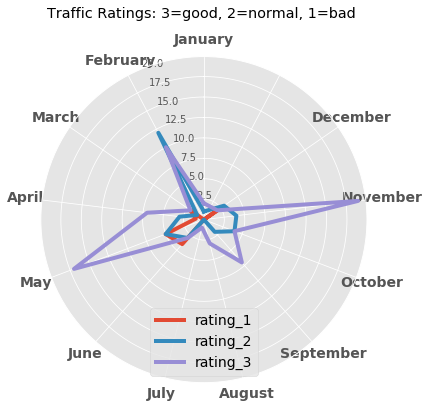

In [19]:
from visualization.visualize import plot_months_polar
plot_months_polar(ratings_per_month)

**Ratings per weekday**

In [20]:
ratings_per_weekday = calculate_ratings_per_time_unit(starting_times_per_trip["trip_start"],
                                      feature_engineered_tracks,
                                      time_unit="weekday")
ratings_per_weekday

,rating_1,rating_2,rating_3
time,,,
0,3,6,10
1,1,4,11
2,7,3,7
3,1,6,16
4,1,11,16
5,1,6,13
6,0,2,4


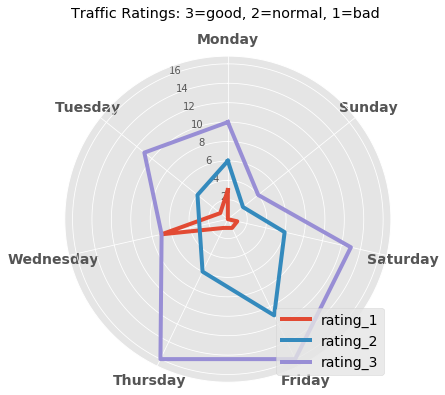

In [21]:
from visualization.visualize import plot_weekdays_polar
plot_weekdays_polar(ratings_per_weekday)

**Ratings per hour of the day**

In [22]:
from visualization.visualize import plot_daytime_polar
ratings_per_daytime = calculate_ratings_per_time_unit(starting_times_per_trip["trip_start"],
                                      feature_engineered_tracks,
                                      time_unit="daytime")
ratings_per_daytime

,rating_1,rating_2,rating_3
time,,,
0,0,0,1
2,0,0,1
3,0,1,4
4,1,2,0
5,0,2,4
6,1,0,4
7,0,4,9
8,0,3,2
9,1,3,8


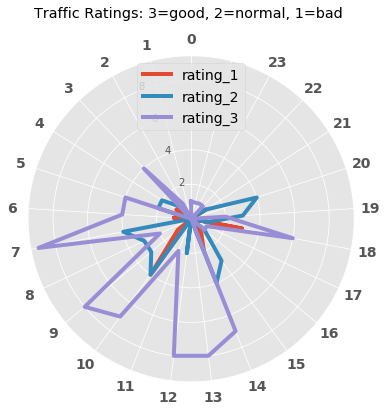

In [23]:
plot_daytime_polar(ratings_per_daytime)

----
## Model Building

**Linear regression model for predicting traffic rating**

In [179]:
from model.train_model import confusion_matrix
from sklearn.model_selection import train_test_split
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop(["time","speed","daytime_end_sinus", "daytime_end_cosinus", "rating"],axis=1),
                                                    feature_engineered_tracks["rating"],
                                                    test_size=0.20, random_state=random_state)

In [162]:


results1 = smf.ols('rating ~ speed + time + distance', data=feature_engineered_tracks).fit()
print("Small Model:\n")
print(results1.summary())
results2 = sm.OLS(y_train, X_train).fit()
print("Large Model:\n")
print(results2.summary())


Small Model:

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.012
Date:                Sun, 19 Nov 2017   Prob (F-statistic):              0.390
Time:                        17:25:51   Log-Likelihood:                -132.37
No. Observations:                 129   AIC:                             272.7
Df Residuals:                     125   BIC:                             284.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4884      0.060     4

**MultiClass Prediction with Logistic Regression**

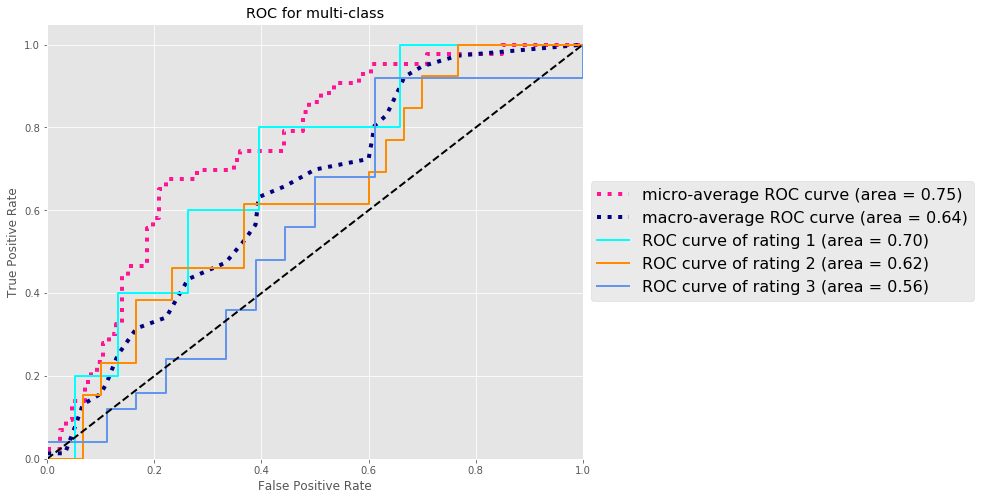

In [123]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from visualization.visualize import plot_multiclass_ROC_curve


y = label_binarize(feature_engineered_tracks["rating"], classes=[1, 2, 3])
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop("rating",axis=1),
                                                    y,
                                                    test_size=0.33, random_state=random_state)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(random_state=random_state,
                                                    solver="sag"))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

plot_multiclass_ROC_curve(y_test, y_score)

**MultiClass Prediction with Random Forest**

Mean Accuracy:  0.465


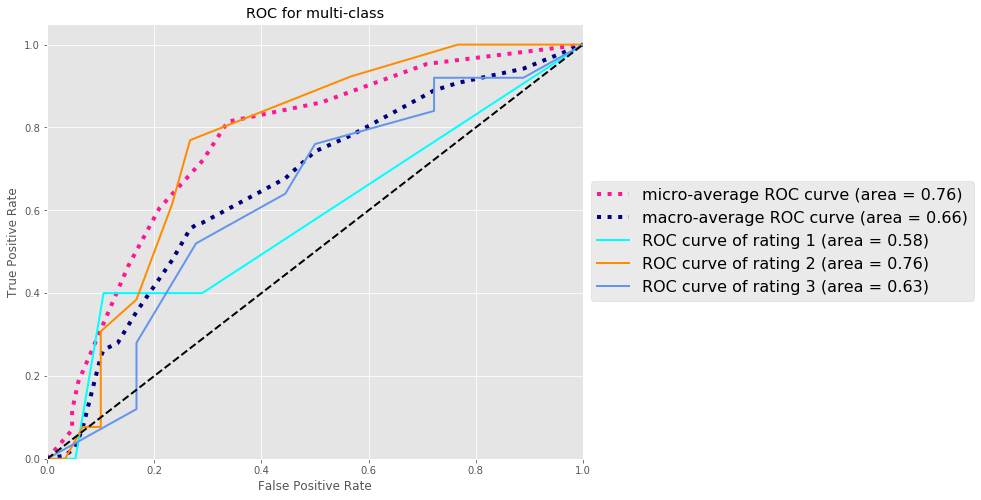

In [180]:
from sklearn.ensemble import RandomForestClassifier 


y = label_binarize(feature_engineered_tracks["rating"], classes=[1, 2, 3])
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop("rating",axis=1),
                                                    y,
                                                    test_size=0.33, random_state=random_state)

rf_classifier = RandomForestClassifier(random_state=random_state,
                                    oob_score=True)
# Learn to predict each class against the other
rf_classifier = OneVsRestClassifier(rf_classifier)
y_score = rf_classifier.fit(X_train, y_train).predict_proba(X_test)

print("Mean Accuracy: ", round(rf_classifier.score(X_test,y_test),3))
plot_multiclass_ROC_curve(y_test, y_score)


In [182]:
from model.train_model import confusion_matrix
from model.train_model import binary_to_multi

prediction = binary_to_multi(y_score)
confusion_matrix(binary_to_multi(y_test),prediction)

  

[3, 3, 3, 2, 3, 3, 3, 2, 3, 1, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 2, 3, 1, 3, 1, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3]


Predicted label,1,2,3
True label,,,
1,1,1,3
2,3,5,5
3,1,5,19


**Use Binary Predictor**
- 1 == Traffic Jam
- 0 == No Traffic Jam


In [166]:
y = list(feature_engineered_tracks["rating"])
y = [1 if (i==1 or i==2) else 0 for i in y]
print("Number of 1: ", sum([1 if i==1 else 0 for i in y]))
print("Number of 0: ", sum([1 if i==0 else 0 for i in y]))
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(feature_engineered_tracks.drop(["time","speed","daytime_end_sinus", "daytime_end_cosinus", "rating"],axis=1),
                                                    y,
                                                    test_size=0.33)

Number of 1:  52
Number of 0:  77


**Binary Class Prediction with Logistic Regression**

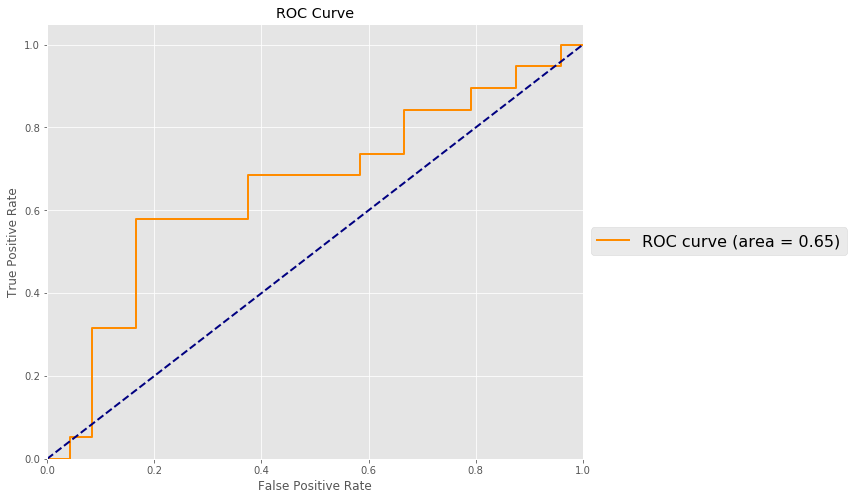

In [167]:
from sklearn.linear_model import LogisticRegression
from model.train_model import report_model_performance
from visualization.visualize import plot_ROC_curve

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(random_state=random_state,
                                                    solver="sag"))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

plot_ROC_curve(y_test, y_score)


**Binary Class Prediction with Random Forest**

prediction probabilities:
       0     1
0  0.66  0.34
1  0.70  0.30
2  0.98  0.02
3  0.18  0.82
4  0.72  0.28
Apply probability threshold at:  0.5
Prediction:
 [0, 0, 0, 1, 0]
True Label:
 [0, 0, 1, 1, 0]
Mean Accuracy:  0.744

Confustion Matrix: 
 Predicted label   0   1
True label             
0                20   4
1                 6  13


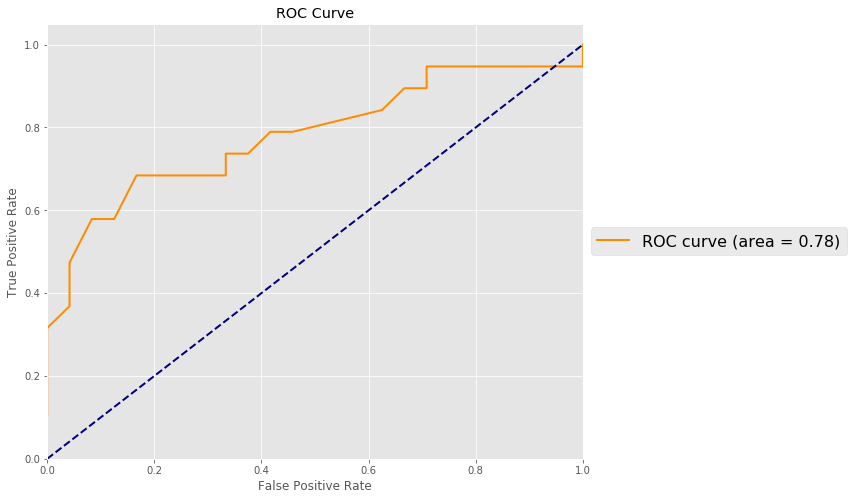

In [174]:
from sklearn.ensemble import RandomForestClassifier 
classifier = RandomForestClassifier(random_state=random_state,
                                    n_estimators = 50,
                                    criterion = "entropy",
                                    oob_score=True)

classifier = classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)

probability_threshold = 0.5
traffic_jam_prediction = [1 if prob[1] >= probability_threshold else 0 \
                          for prob in y_score]

print("prediction probabilities:\n",pd.DataFrame(y_score[0:5],columns=[0,1]))
print("Apply probability threshold at: ", probability_threshold)
print("Prediction:\n", traffic_jam_prediction[0:5])
print("True Label:\n", [i for i in y_test[0:5]])
print("Mean Accuracy: ", round(classifier.score(X_test,y_test),3))
print("\nConfustion Matrix: \n",confusion_matrix(y_test,traffic_jam_prediction))

prediction_probabilities_class_1 = y_score[:,1]
plot_ROC_curve(y_test, prediction_probabilities_class_1)


**Majority Vote for traffic rating prediction**